### **Trabajo Final para la Cátedra de Fundamentos de Analítica I**
#### El objetivo del presente proyecto es la supervivencia en el Titanic, así como establecer una caracterización de los sobrevivientes y de aquellos que tuvieron el mismo final que Jack.

##### Realizado por:
  - Claudia Lorena Aragón
  - Álvaro José Cabrera
  - Álvaro Rodríguez Lasso
  - Alfredo Aponte Segura

In [2]:
# Import de librarias necesarias para el proyecto
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

#  Visualization
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Funciones para análisis de atípicos
from scipy.stats import skew, kurtosis  ## funciones estadísticas
def tabla_descriptivas(columnas):
    tabla_descriptivas=pd.DataFrame(columnas.describe())
    tabla_descriptivas.loc['coef. variation 0.30 | 0.30-0.70 | 0.70']=columnas.std()/columnas.mean()
    tabla_descriptivas.loc['skew < 0 sesgo izquierda | > 0 sesgo derecha ']=skew(columnas) #Sesgo o asimetría
    tabla_descriptivas.loc['kurtosis <0 achatada platicurtica | > 0 empinada leptocurtica']=kurtosis(columnas)
    q1=columnas.quantile(0.25)
    q3=columnas.quantile(0.75)
    IQR=q3-q1
    outliers = columnas[ ((columnas<(q1-1.5*IQR)) | (columnas>(q3+1.5*IQR))) ]
    outlier_minimos = columnas[columnas<(q1-1.5*IQR)]
    outlier_maximos = columnas[columnas>(q3+1.5*IQR)]
    tabla_descriptivas.loc['Umbral atípicos minimo']=  columnas.quantile(0.25) - (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    tabla_descriptivas.loc['Umbral atípicos maximo']=  columnas.quantile(0.75) + (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    #tabla_descriptivas.loc['cantidad atipicos minimos']=   len(outlier_minimos)
    #tabla_descriptivas.loc['cantidad atipicos maximos']= len(outlier_maximos)
    #tabla_descriptivas.loc['cantidad_total_atípicos']= len(outliers)
    return tabla_descriptivas

### 1. Limpieza y EDA

#### Cargue de datos

In [3]:
df_completo = pd.read_csv("/content/sample_data/train.csv") #Dataset completo
#Split de datasets para generar un set de test por python, dado que no hay etiquetas en el set de test de Kaggle.
df_train, df_test = train_test_split(df_completo, test_size=0.2, random_state=42)
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.500,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.925,NaN,S


#### Validación general de formatos del dataset, datos faltantes y duplicados

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [5]:
df_train.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.662921
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.668539
Embarked        0.280899
dtype: float64

In [6]:
df_train.duplicated().sum()

0

Encontramos un data set de entrenamiento con 891 registros. Las variables se encuentran correctamente formateadas.  Sin embargo, la variable "Cabin", presenta un 77% de datos faltantes por lo que se descartará del análisis posteriormente.  Por otro lado las variables "Age" y "Embarked" presentan aproxidamente un 20% de datos faltantes, por lo que se deberán imputar. FInalmente, no se presentan valores duplicados.

#### Eliminación de variables innecesarias del dataset

In [7]:
df_train = df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df_test = df_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

Eliminamos variables cualitativas que no nos aportan en nuestro objetivo o presentan mayor proporción de valores nulos: "PassengerId", "Name", "Ticker", "Cabin".  Adicionalmente, la cabina se explica con la clase de la persona (multicolinealidad).

#### Análisis descriptivo

#### Distribución de las variables cuantitativas

In [8]:
tabla_descriptivas(df_train[['Age', 'SibSp','Parch','Fare']])

,Age,SibSp,Parch,Fare
count,572.000000,712.000000,712.000000,712.000000
mean,29.498846,0.553371,0.379213,32.586276
std,14.500059,1.176404,0.791669,51.969529
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.925000
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,30.500000
max,80.000000,8.000000,6.000000,512.329200
coef. variation 0.30 | 0.30-0.70 | 0.70,0.491547,2.125888,2.087661,1.594829
skew < 0 sesgo izquierda | > 0 sesgo derecha,NaN,3.611755,2.689777,4.864789


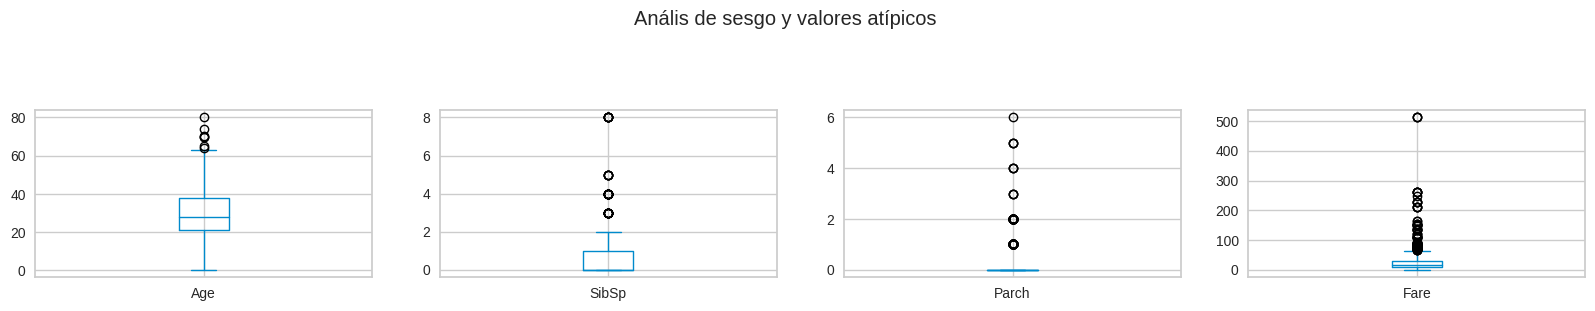

In [9]:
df_atipicos = df_train.drop(columns=['Pclass', 'Sex', 'Embarked', 'Survived'])
boxplot = df_atipicos.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,10), title='Anális de sesgo y valores atípicos', color="#008ACC" )
plt.show()

Age:

-El 50% de la distribución de los datos se encuentra entre 20 y 38 años, con centro 28, es decir adultos jóvenes.

-Presenta unos cuantos atípicos de cara a edades máximas, superiores a 64 años. Son datos válidos.

Sibsp (nro. hermanos / cónyuges aboard the Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 1, con centro 0.

-Presenta unos cuantos atípicos máximos superiores a 2.

Parch (Nro. de padres / hijos a bordo del Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 0, con centro 0.

-Presenta unos cuantos atípicos máximo superiores a 0.

Fare (Tarifa)

-El 50% de la distribución de los datos se encuentra entre 7.91 y 31, con centro 14.4.

-Presenta una gran cantidad de datos atípicos, con valores superioes a 65.

#### Relación de variables cuantitativas Vs. variable objetivo y separación de tipo de variables

In [10]:
#Coerción y marcación de variables para graficar
df_train['Survived'] = df_train['Survived'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_test['Survived'] = df_test['Survived'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_train['Pclass'] = df_train['Pclass'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_test['Pclass'] = df_test['Pclass'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización



# Separando las variables cuantitativas de las cualitativas
# Las variables cuantitativas son 'Age' y 'Fare'
quantitative_cols = ['Age', 'SibSp','Parch','Fare']
# Las variables cualitativas son 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
qualitative_cols = ['Pclass', 'Sex', 'Embarked']

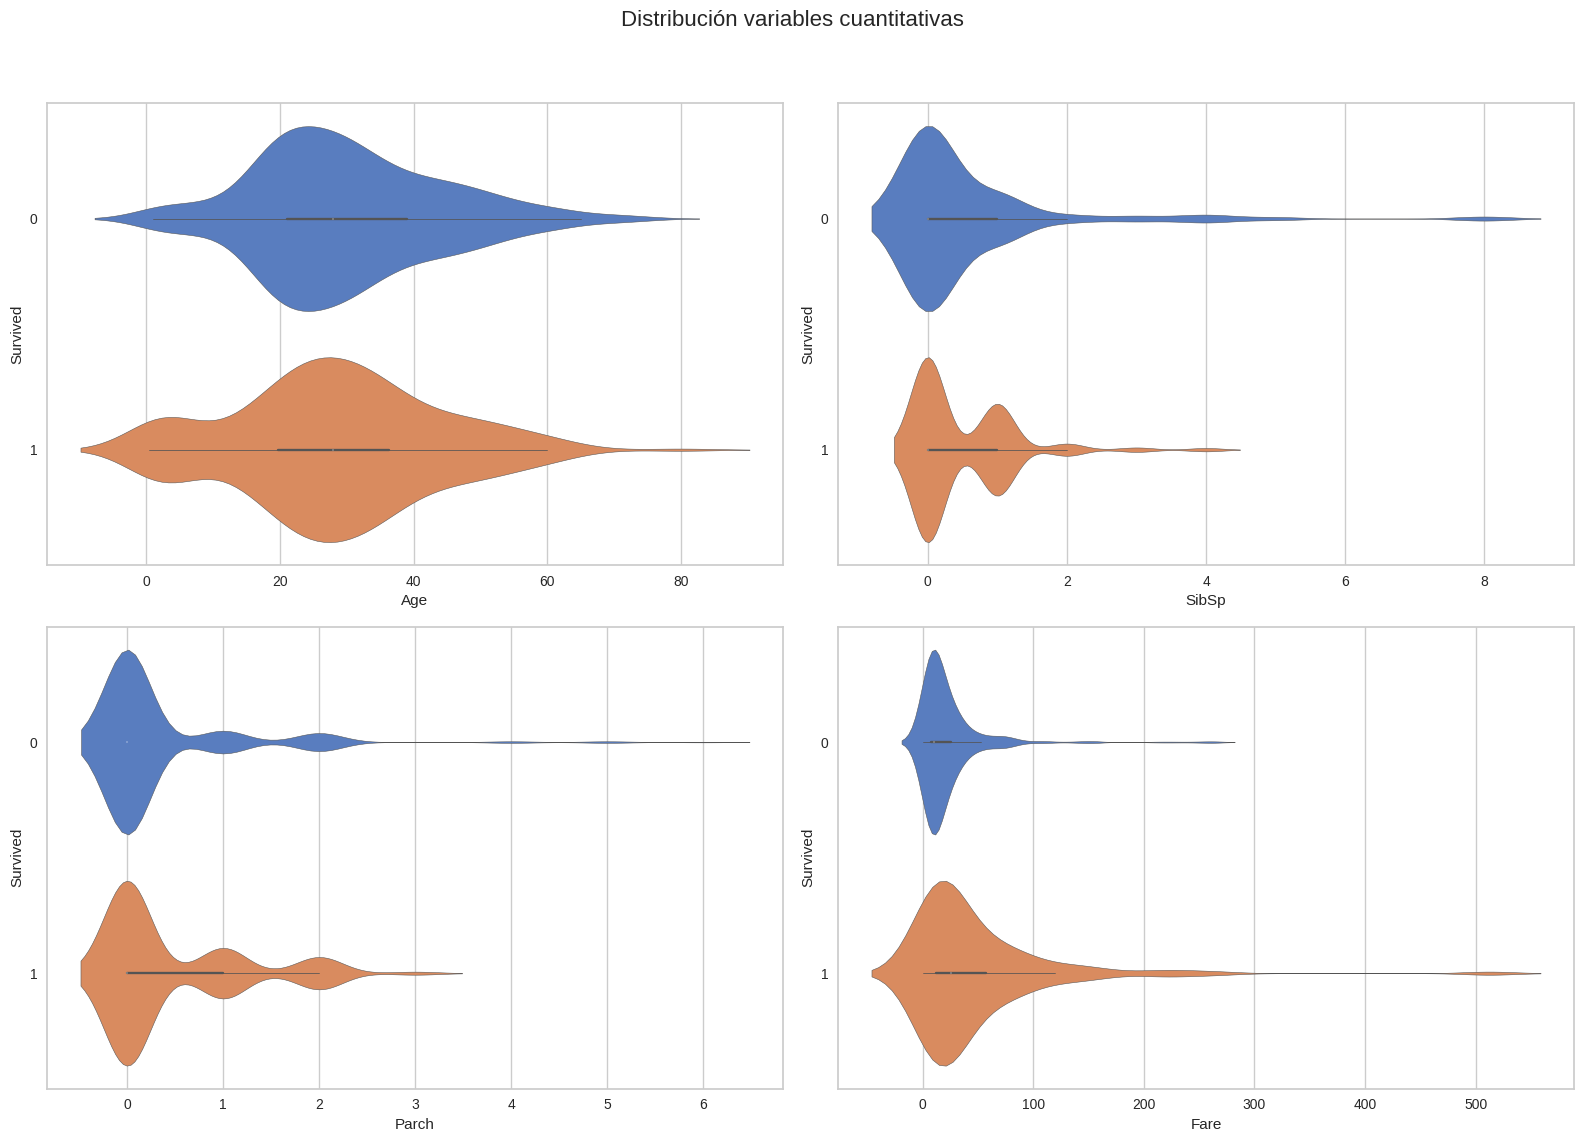

In [11]:
# Crear un tablero para gráficos de violín de variables cuantitativas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Distribución variables cuantitativas', fontsize=16)

for i, col in enumerate(quantitative_cols):
    ax = axes[i // 2, i % 2] # distribución del gráfico en la cuadrículas
    sns.violinplot(y='Survived', x=col, data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # espacios de los subplots
plt.show()

Edad:

Los sobrevivientes presentan una mayor frecuencia en edades bajas y menores frecuencias en edades muy avanzadas.

Sibsp (nro. hermanos / cónyuges aboard the Titanic):

Los sobrevivientes presentan dos grupos claramente identificables: sin sibsp o con 1 sibsp, estos últimos presentan mayor frecuencia que en los fallecidos.  En los fallecidos estos dos grupos no se ven tan claramente, además que presentan datos atípicos máximos: lo anterior implica que en el test de entrenamiento no se salvaron familias numerosas.

Parch (Nro. de padres / hijos a bordo del Titanic)

En los sobrevivientes existe más frecuencia en los valores 1 y 2

Fare (Tarifa)

Los sobrevivientes tienen su centro de distribución un poco más arriba que los fallecidos.   Adicionalmente, en los sobrevivientes se observa datos atípicos con valores muy altos.

#### Análisis visual de correlación

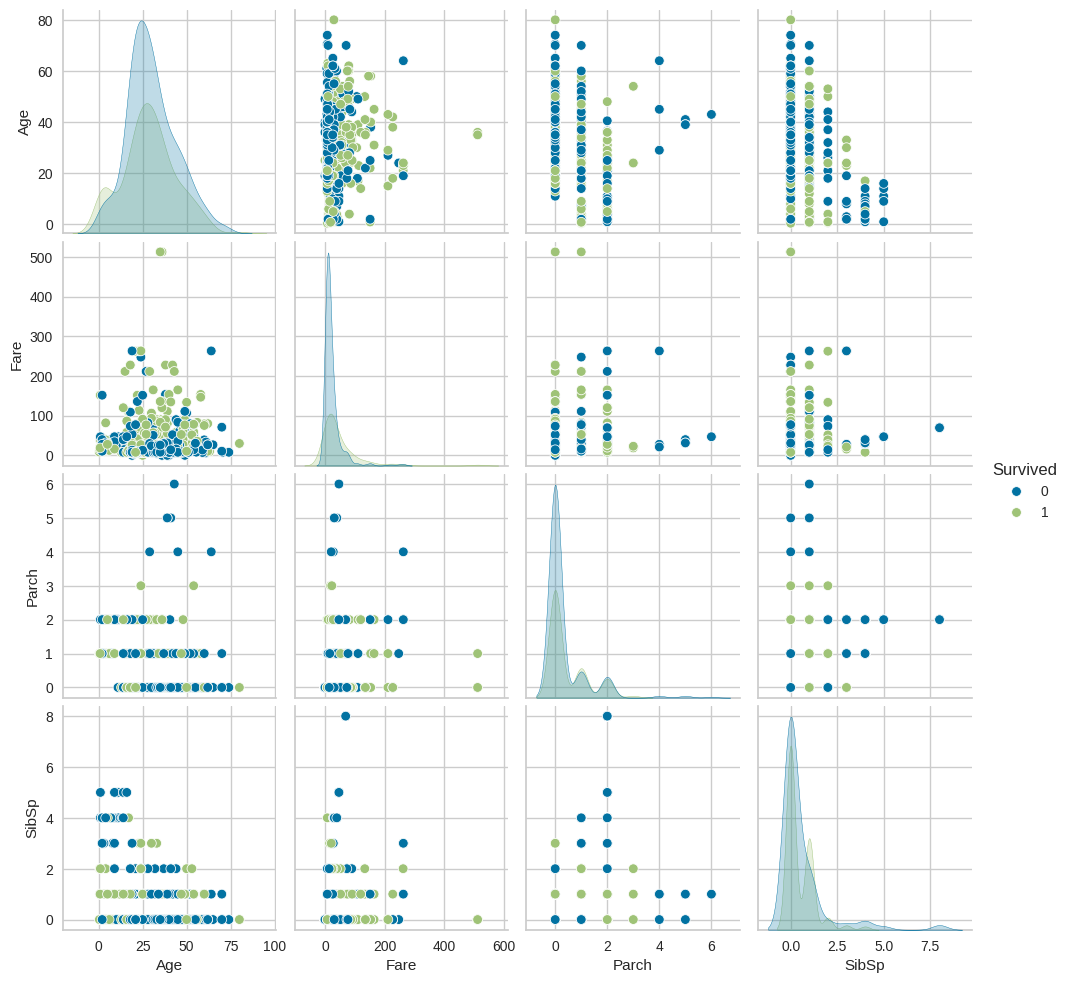

In [12]:
palette = {0: "red", 1: "green"}
sns.pairplot(data=df_train[['Age', 'Fare', 'Parch', 'SibSp','Survived']], hue="Survived")

•Interpretación
* Age: Edad de los pasajeros. La edad más frecuente entre los pasajeros del titánica fue 25 años en los fallecidos
•
*	Fare: La tarifa del boleto pagado por los pasajeros más frecuente fue un valor muy mínimo cercano a 0 en fallecidos.
*	Parch: El número de padres e hijos a bordo más frecuente fue de cero (0) en fallecidos, es decir que no iban con padre o hijos en el titánica.
*	SibSp: Se observa que la mayoría de los pasajeros fueron los fallecidos que no tenían hermanos ni conyugue es decir más frecuente 0.


•	Gráficos de dispersión:
*	Age vs. Fare: No se observa una correlación lineal entre la edad y el costo del boleto; por lo que el pago de tarifa en sobrevivientes y no sobrevivientes no tiene una tendencia lineal, es decir que no incide la edad en el pago de la tarifa
*	Age vs. Parch: No hay una tendencia clara en la relación entre edad y número de padres/hijos a bordo. Observándose que la mayor concentración de puntos con respecto a Parch de 0 y algunos valores atípicos en esta variable con un numero de 6 padres/hijos a bordo.
*	Age vs. SibSp: No hay una tendencia clara entre edad y número de hermanos/cónyuges a bordo.
*	Fare vs. Parch: La mayoría de los pasajeros con Parch = 0 pagaron tarifas bajas. Algunos con Parch > 0 pagaron tarifas más altas, pero no hay una tendencia clara.
*	Fare vs. SibSp: Los pasajeros con más hermanos/cónyuges tienden a haber pagado tarifas variadas, pero sin una tendencia clara.
*	Parch vs. SibSp: Algunos tienen combinaciones de valores más altos, pero son menos comunes.


#### Análisis de variables cualitativas

In [13]:
""""
# Visualización de variables cualitativas vs Survived
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('', fontsize=16)

for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='Survived', data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
"""

'"\n# Visualización de variables cualitativas vs Survived\nfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))\nfig.suptitle(\'\', fontsize=16)\n\nfor i, col in enumerate(qualitative_cols):\n    ax = axes[i]\n    sns.countplot(x=col, hue=\'Survived\', data=df_train, ax=ax, palette="muted")\n\nplt.tight_layout(rect=[0, 0.03, 1, 0.95])\nplt.show()\n'

PClass1:  la clase mayoritaría son los sobrevivientes.

PClass2:  la clase de fallecidos, está un poco por encima de sobrevivientes.

PClass3:  la clase de fallecidos es la mayoritaria.

Male: la clase mayoritaria es fallecidos.

Famale: la clase mayoritaria es sobreviviente.

Southampton (S , clase media y alta 50%, clase baja  50%): la clase mayoritaria es fallecidos.

Cherbourg (C, mayoritariamente clase alta 1): la clase mayoritaria es sobreviviente.

Queenstown (Q, mayoritariamente clase baja 3):  la clase mayoritaria  es fallecidos.

#### Label encoding

In [14]:
mapping_pclass   = {'1': 'Upper', '2': 'Middle', '3': 'Lower'}
mapping_survived = {'1': 'Survived', '0': 'No'}

# Reemplazar los valores en la columna 'Pclass'
df_train['Pclass'] = df_train['Pclass'].replace(mapping_pclass)
df_test['Pclass'] = df_test['Pclass'].replace(mapping_pclass)

df_train['Survived'] = df_train['Survived'].replace(mapping_survived)
df_test['Survived'] = df_test['Survived'].replace(mapping_survived)

#### Visualización de datos faltantes previo a imputación

<Axes: >

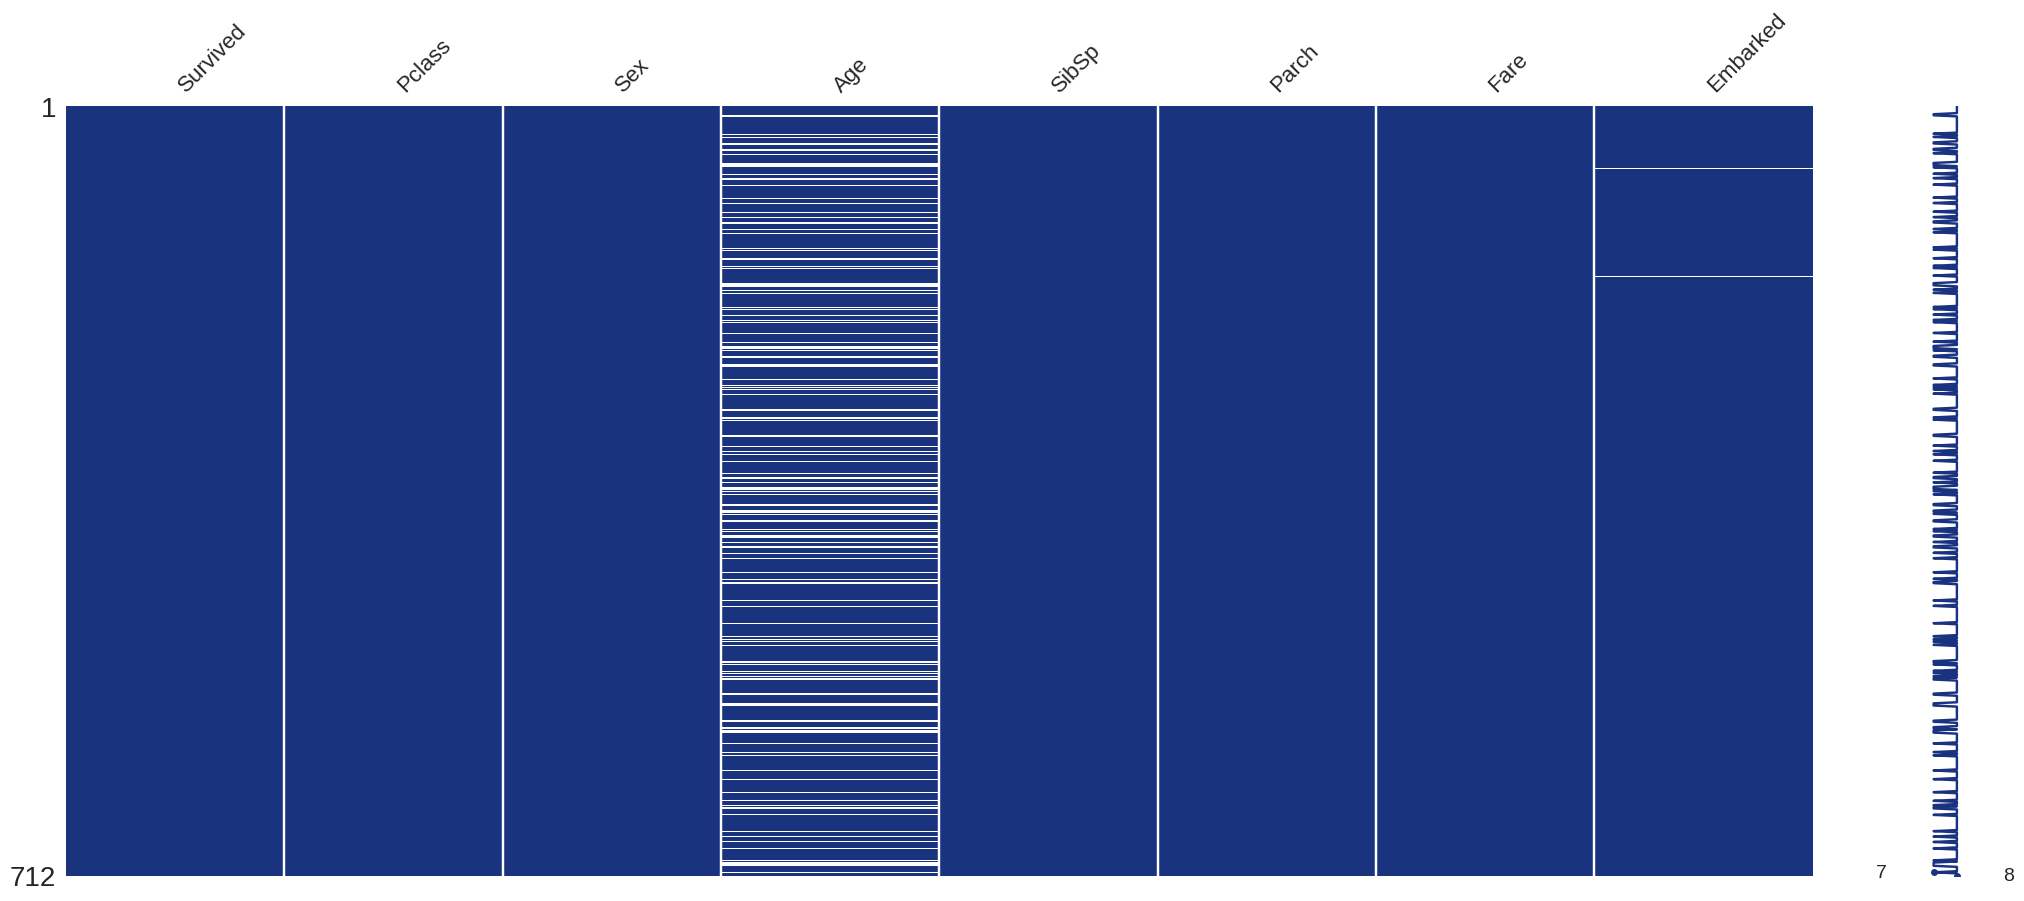

In [15]:
msno.matrix(df_train, color = (0.1, 0.2, 0.5)) #print(msno.matrix(df_train))

#### Imputación

<Axes: >

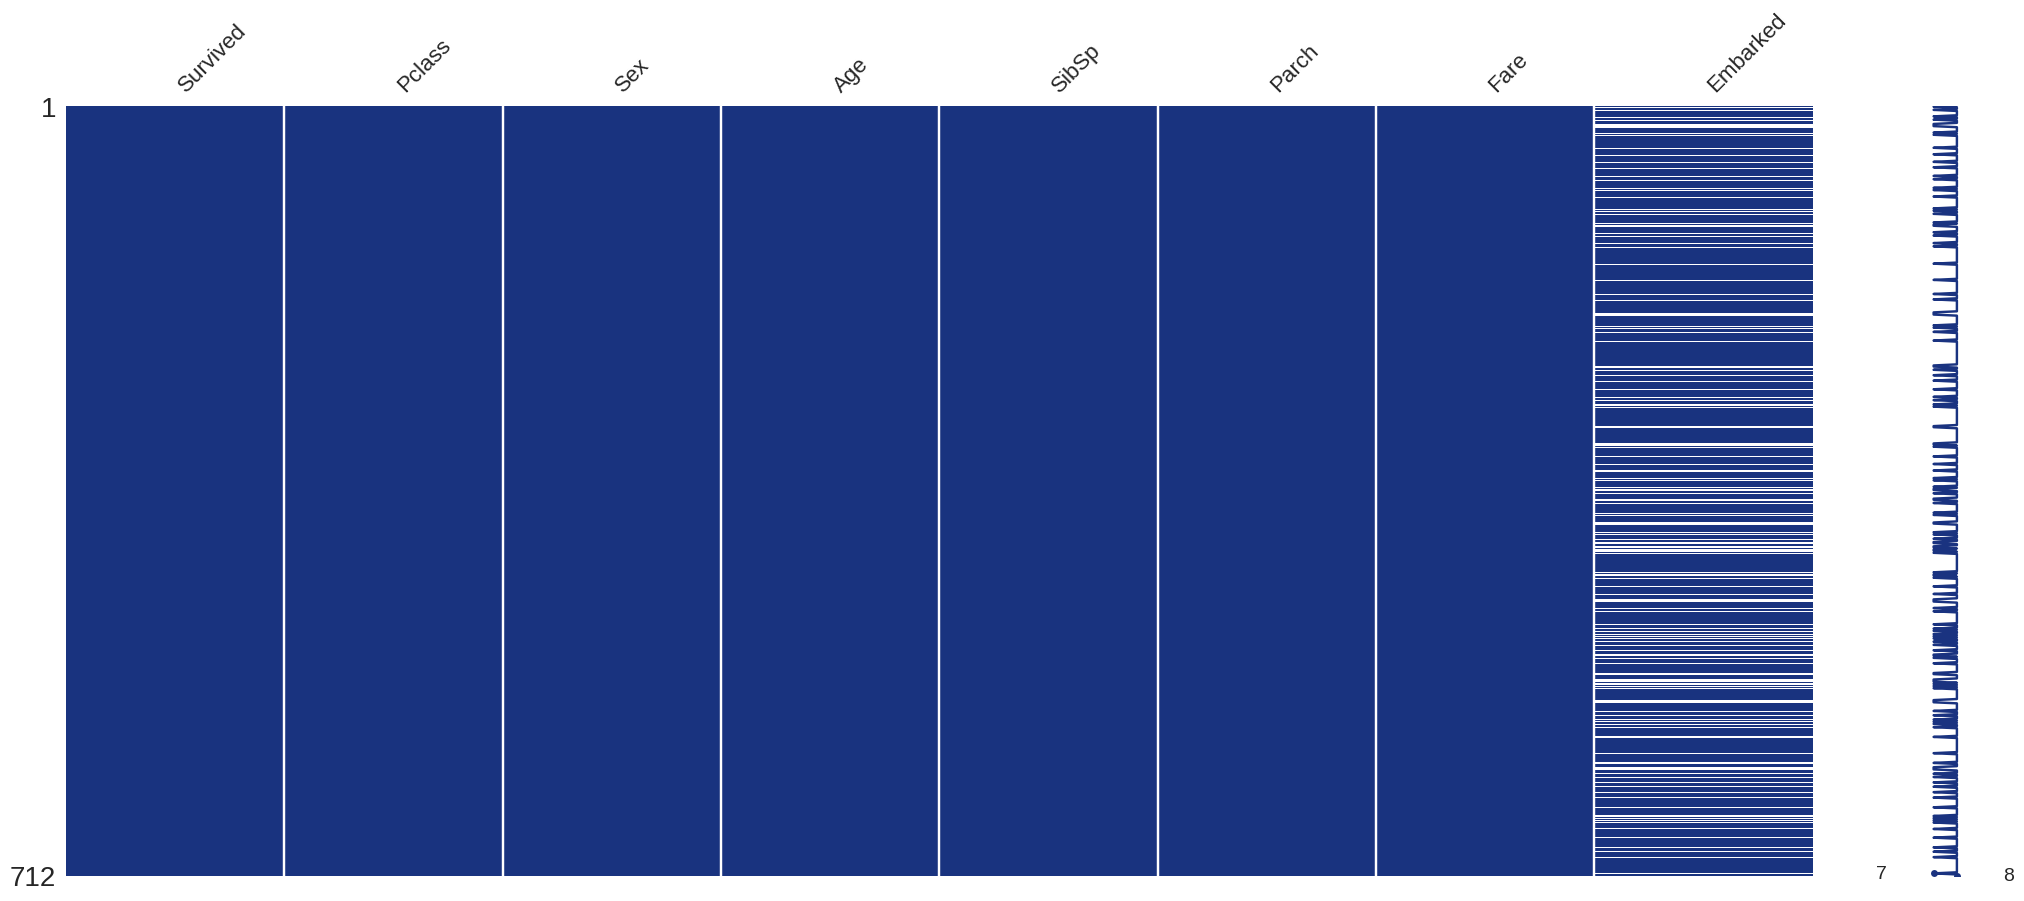

In [16]:
# Imputación #
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df_train[['Embarked']]), columns=['Embarked'])
df_train['Embarked']=df_imputed['Embarked']


# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_train[quantitative_cols] = knn_imputer.fit_transform(df_train[quantitative_cols])

#-----------------------------------------------------------------------------------------

#### Segundo datasets
# Imputación #
df_imputed2 = pd.DataFrame(imputer.fit_transform(df_test[['Embarked']]), columns=['Embarked'])
df_test['Embarked']=df_imputed2['Embarked']


# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_test[quantitative_cols] = knn_imputer.fit_transform(df_test[quantitative_cols])

# Visualiza la matriz de valores faltantes después de la imputación
msno.matrix(df_train, color = (0.1, 0.2, 0.5))

Se observa que los valores han sido correctamente imputados

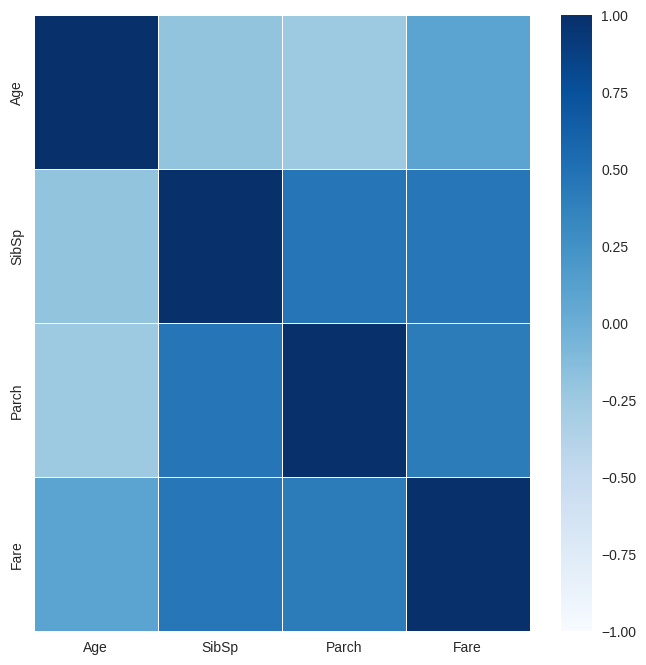

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [17]:
# Calcular la matriz de correlación de Spearman
corr_matrix = df_train[quantitative_cols].corr(method='spearman')

# Crear un heatmap de la matriz de correlación
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, cmap='Blues', vmin=-1, vmax=1, linewidths=0.5, linecolor='white')
plt.show()
df_train.columns

In [18]:
#Selección de matriz de entrenamiento y de prueba
X_train=df_train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
X_test=df_test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y_train=df_train.iloc[:,0]
y_test=df_test.iloc[:,0]
y_train = y_train.replace({'No': 0, 'Survived': 1})
y_test = y_test.replace({'No': 0, 'Survived': 1})

In [19]:
# One-hot encode the categorical columns
X_train_encoded = pd.get_dummies(X_train[qualitative_cols], columns=qualitative_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test[qualitative_cols], columns=qualitative_cols, drop_first=True)
# Combine the encoded categorical columns with the numerical columns
X_train_final = pd.concat([X_train_encoded, X_train.drop(columns=qualitative_cols)], axis=1)
X_test_final = pd.concat([X_test_encoded, X_test.drop(columns=qualitative_cols)], axis=1)
X_test_final

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare
709,False,True,True,False,False,23.8,1.0,1.0,15.2458
439,True,False,True,False,False,31.0,0.0,0.0,10.5000
840,False,True,True,False,False,20.0,0.0,0.0,7.9250
720,True,False,False,False,False,6.0,0.0,1.0,33.0000
39,False,True,False,False,True,14.0,1.0,0.0,11.2417
...,...,...,...,...,...,...,...,...,...
433,False,True,True,False,False,17.0,0.0,0.0,7.1250
773,False,True,True,False,False,23.2,0.0,0.0,7.2250
25,False,True,False,False,True,38.0,1.0,5.0,31.3875
84,True,False,False,False,False,17.0,0.0,0.0,10.5000


### 2. Modelos predictivos

In [20]:
def print_reports(title, y_test, y_pred):
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(title)
    plt.show()

    print("Reporte de clasificación:")
    target_names = ['No', 'Survived']
    print(classification_report(y_test, y_pred, target_names=target_names))

#### 2.1 Regresion Logistica

In [21]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_final, y_train)

y_pred = logreg.predict(X_test_final)

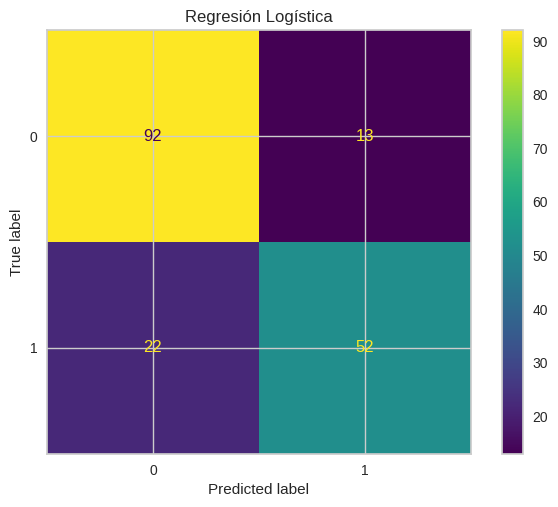

Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.81      0.88      0.84       105
    Survived       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [22]:
print_reports('Regresión Logística',y_test, y_pred)


**Precisión (Accuracy):** La precisión general del modelo es del 80%, lo que significa que alrededor del 80% de las predicciones son correctas en general.

**Sensibilidad (Recall o Tasa de Verdaderos Positivos):** La sensibilidad para la clase “Survived” (sobrevivientes) es del 70%, lo que indica que alrededor del 70% de los casos positivos se detectan correctamente.

**Especificidad (Tasa de Verdaderos Negativos):** La sensibilidad para la clase “No Survived” (No sobrevivieron) es del 88% de los casos negativos se detectan correctamente.

**Valor F1 (F1-Score):** El valor F1 es del 75%, que combina precisión y sensibilidad en una sola métrica.

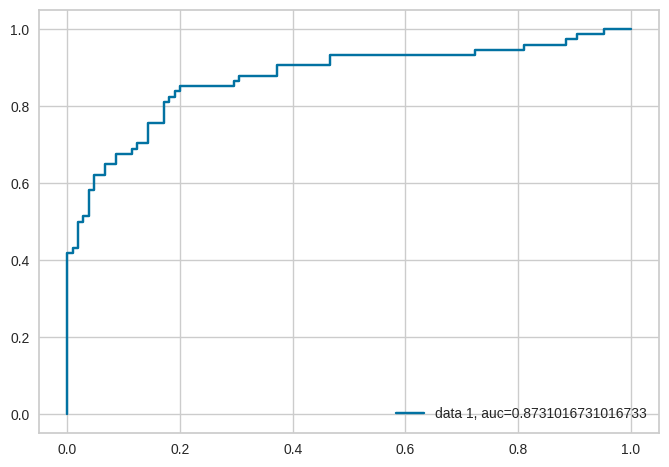

In [23]:
y_pred_proba = logreg.predict_proba(X_test_final)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

La curva ROC (Receiver Operating Characteristic) es una herramienta utilizada para evaluar el rendimiento de un modelo de clasificación binaria. Representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a medida que se varía el umbral de decisión del modelo.

En el eje X, tenemos el FPR (tasa de falsos positivos), que mide la proporción de instancias negativas incorrectamente clasificadas como positivas. En el eje Y, tenemos el TPR (tasa de verdaderos positivos), que mide la proporción de instancias positivas correctamente clasificadas como positivas.

El área bajo la curva (AUC) resume la capacidad del modelo para distinguir entre las clases. Cuanto más cerca esté la curva del rincón superior izquierdo, mejor será el rendimiento del modelo. En este caso, el AUC es aproximadamente **0.873**, lo que sugiere que este clasificador tiene una buena capacidad de discriminación.

#### 2.2 Random Forest

##### 2.2.1 Modelo Inicial

In [24]:
rf = RandomForestClassifier( random_state=42)
rf.fit(X_train_final, y_train)
y_pred = rf.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)


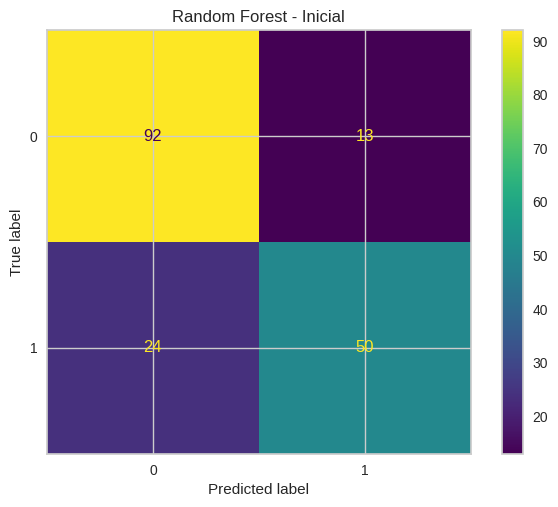

Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.79      0.88      0.83       105
    Survived       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [25]:
print_reports('Random Forest - Inicial', y_test, y_pred)

La información anterior corresponde a las metricas del modelo **antes** de optimizar los hiperparámetros:

**Precisión (Precision):** Para la clase “No”, la precisión es 0.79, lo que significa que alrededor del 79% de las predicciones positivas para “No” fueron correctas. Para la clase “Survived”, la precisión también es 0.79.

**Recall (Sensibilidad):** El recall mide la proporción de instancias positivas reales que se predijeron correctamente. Para la clase “No”, el recall es 0.88, lo que indica que alrededor del 88% de las instancias reales de “No” se predijeron correctamente. Para la clase “Sobrevivido”, el recall es 0.68.

**F1-Score:** El F1-score es una métrica que combina precisión y recall en una sola medida. Para la clase “No”, el F1-score es 0.83, y para la clase “Survived”, es 0.73.

**Soporte (Support):** El soporte representa el número de instancias en cada clase. Para la clase “No”, el soporte es 105, y para la clase “Survived”, es 74.

**Promedio (Average):** La tabla también proporciona tres promedios:

*-Promedio general (Accuracy):* La precisión general del modelo es **0.79**.

 *- Promedio ponderado (Weighted avg):* Es el promedio ponderado de las métricas, considerando el soporte de cada clase. En este caso, el recall ponderado es 0.78.

 *-Promedio no ponderado (Macro avg):* Es el promedio no ponderado de las métricas. En este caso, el recall no ponderado es 0.79.

##### 2.2.2 Optimización de Hiperparámetros

In [26]:
# En este caso, se están optimizando 'n_estimators' y 'max_depth'. #'n_estimators' se refiere al
# número de árboles en el bosque y 'max_depth' # es la profundidad máxima de los árboles.
# Los valores para estos hiperparámetros se seleccionarán aleatoriamente de los rangos proporcionados
# (entre 50 y 500 para 'n_estimators' y entre 1 y 20 para 'max_depth').
param_dist = {'n_estimators'     : randint(10, 600),
              'max_depth'        : randint(1, 30),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf' : randint(1, 4),
              'max_features'     : ['auto', 'sqrt', 'log2', None]}
import random
random.seed(42)

# Create a random forest classifier
rf = RandomForestClassifier( random_state=42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7856168c7d60>,
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78561664c280>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x785616809270>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x785616827d60>})

In [27]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 94}


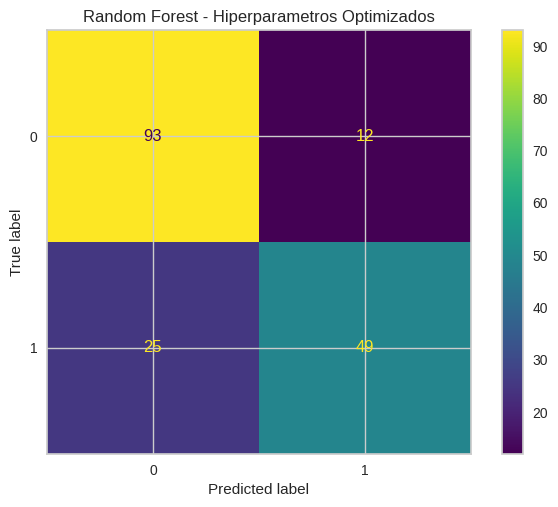

Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.79      0.89      0.83       105
    Survived       0.80      0.66      0.73        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



In [28]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test_final)

# Create the confusion matrix
print_reports('Random Forest - Hiperparametros Optimizados',y_test, y_pred)

Una vez ajustados los hiperparámetros, se encuentra la siguiente información:


**Precisión (Precision):**

   *-Antes:* La precisión para la clase “No” era 0.80, mientras que para la clase “Survived” era 0.80.

   *-Después:* La precisión para la clase “No” mejoró ligeramente a 0.83, y para la clase “Survived” se mantuvo en 0.83.

**Recall (Sensibilidad):**

   *-Antes:* El recall para la clase “No” era 0.88, y para la clase “Survived” era 0.69.

   *-Después:* El recall para la clase “No” disminuyó a 0.66, y para la clase “Survived” aumentó a 0.90.

**F1-Score:**

   *-Antes:* El F1-score para la clase “No” era 0.84, y para la clase “Survived” era 0.74.
   
   *-Después:* El F1-score para la clase “No” se mantuvo en 0.84, y para la clase “Survived” aumentó ligeramente a 0.74.

**Soporte (Support):**

   El soporte (número de instancias) se mantuvo igual en ambos casos (105 para “No” y 74 para “Survived”).

El modelo después de la optimización de hiperparámetros tiene una mayor sensibilidad (recall) para la clase “Survived”, lo que significa que está prediciendo correctamente más casos de supervivencia. Sin embargo, la precisión para ambas clases se mantuvo estable.

El modelo después de la optimización parece ser más equilibrado en términos de precisión y recall, lo que podría ser beneficioso cuando buscamos identificar los pasajeros que sobrevivieron.

<Axes: >

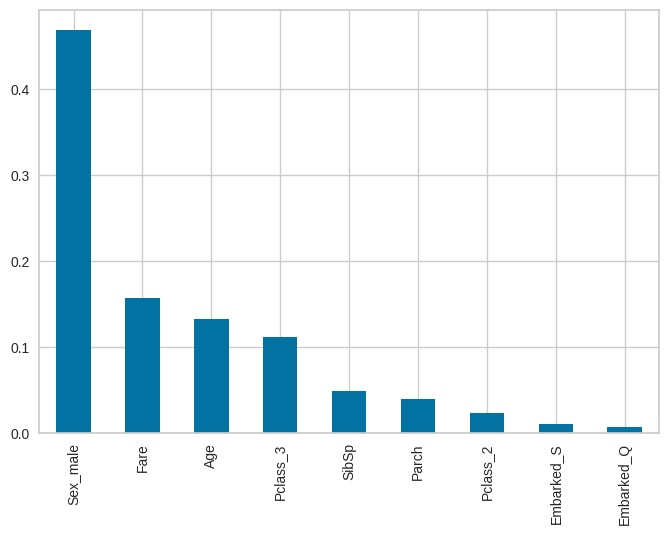

In [29]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_test_final.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

Cada barra en el gráfico representa una característica del conjunto de datos, y la altura de la barra indica la importancia de esa característica.
Este gráfico nos permite identificar  las características son las más influyentes en las predicciones del modelo, siendo:
- Sexo
- Tarifa (Fare)
- Edad (Age)

las 3 caracteristicas que mejor describen el modelo.

#### 2.3 Decision Tree

##### 2.3.1 Modelo Inicial

In [30]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=42)

# Train Decision Tree Classifer
clf = clf.fit(X_train_final,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)


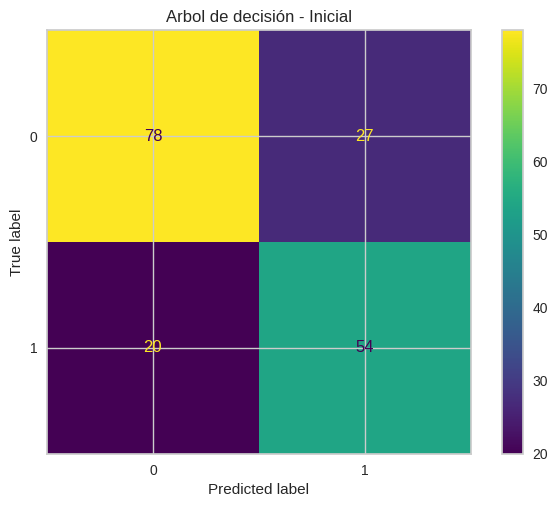

Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.80      0.74      0.77       105
    Survived       0.67      0.73      0.70        74

    accuracy                           0.74       179
   macro avg       0.73      0.74      0.73       179
weighted avg       0.74      0.74      0.74       179



In [31]:
print_reports('Arbol de decisión - Inicial',y_test, y_pred)

In [32]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7374301675977654


In [33]:

# Create Decision Tree classifer object with max_depth=3
clf = DecisionTreeClassifier(max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_final, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)


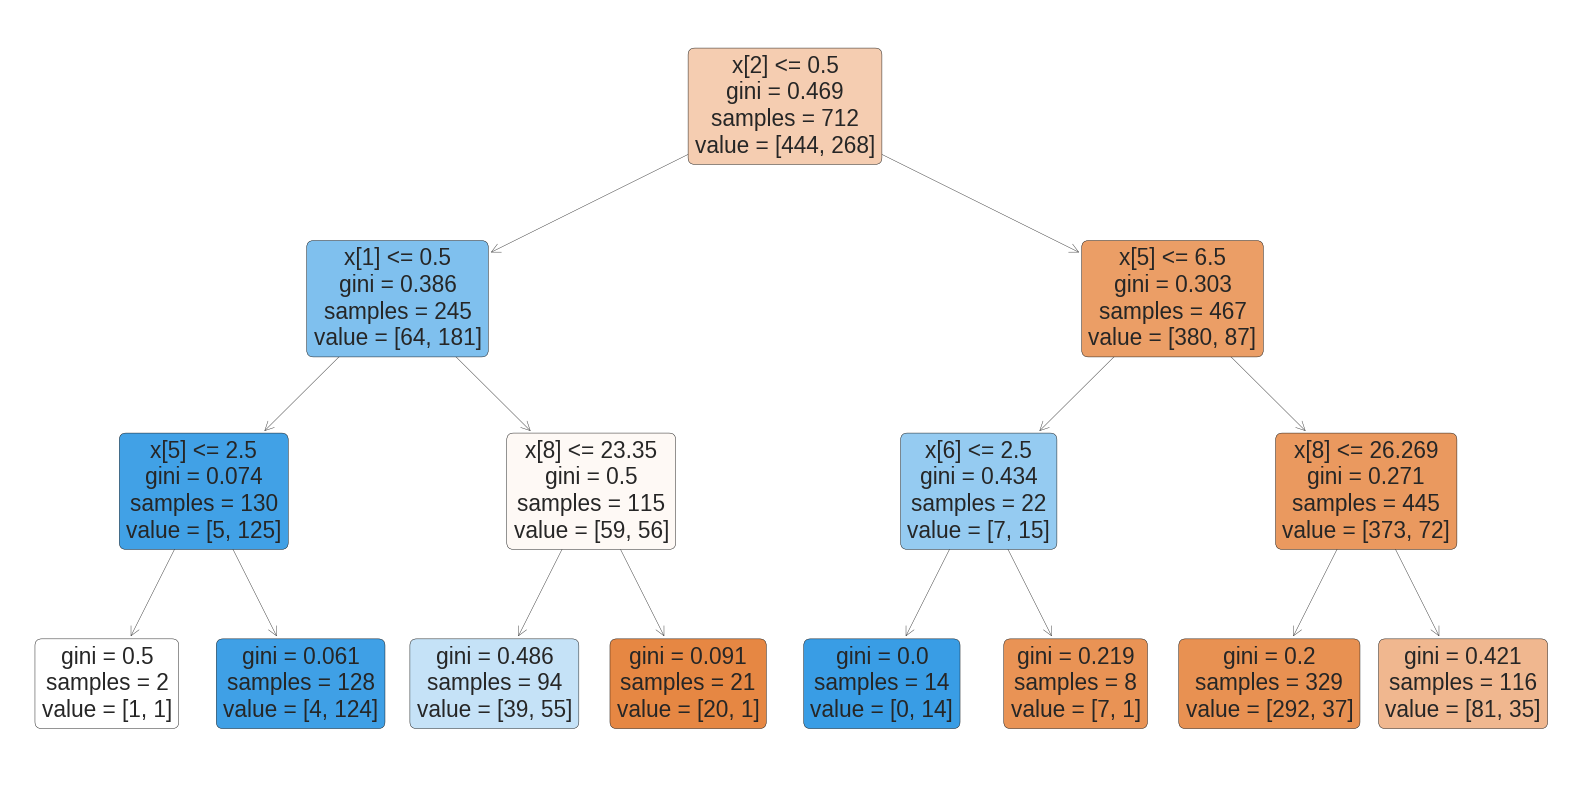

In [34]:

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, rounded=True)
plt.show()

##### 2.3.2 Optimización de Hiperparámetros

In [35]:

# Paso 3: Definir el modelo
dt = DecisionTreeClassifier(random_state=42)

# Paso 4: Definir los hiperparámetros a probar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5,10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Paso 5: Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_final, y_train)

# Paso 6: Obtener los mejores parámetros y evaluar el modelo
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_final)

print("Exactitud:")
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Exactitud:
0.7988826815642458


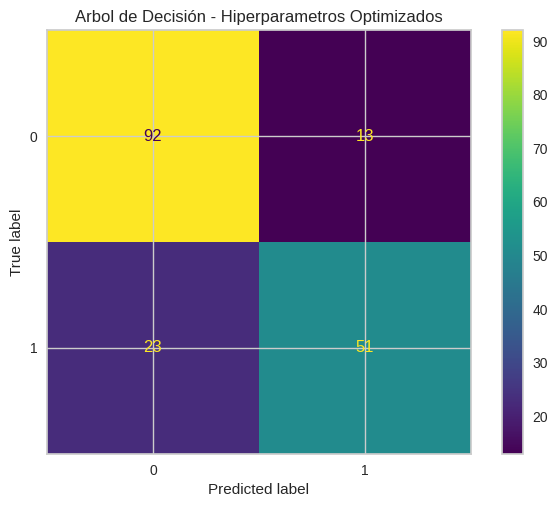

Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.80      0.88      0.84       105
    Survived       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [36]:
# Create the confusion matrix
print_reports('Arbol de Decisión - Hiperparametros Optimizados',y_test, y_pred)

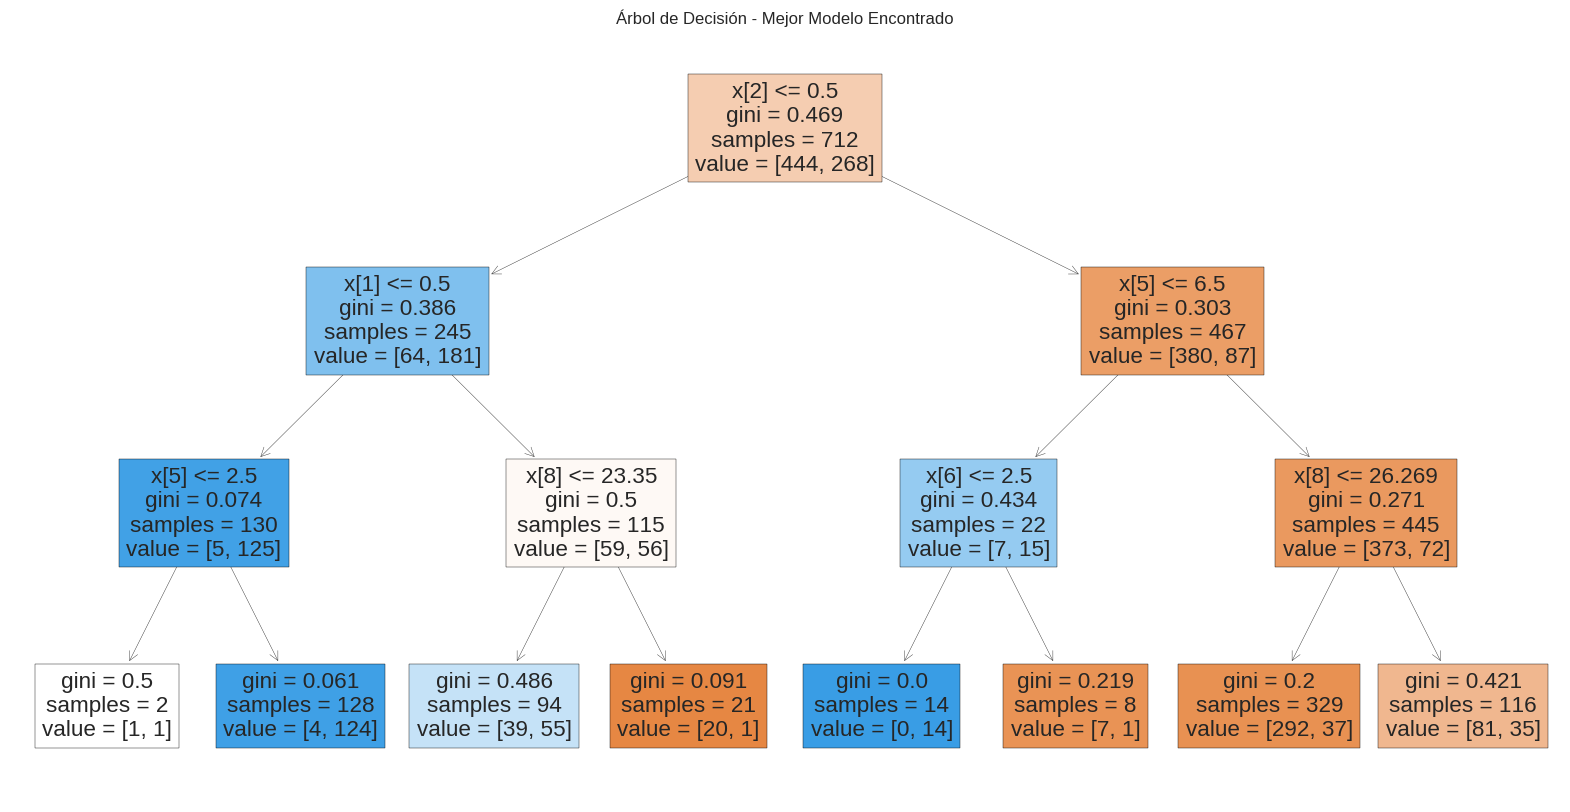

In [37]:
# Paso 7: Graficar el mejor árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(best_model,filled=True)
plt.title("Árbol de Decisión - Mejor Modelo Encontrado")
plt.show()

#### **EXTRA** 2.3.X Ampliando la manera de seleccionar el modelo. **EXTRA**

##### Cargamos , revisamos y limpiamos los datos de una manera distinta

In [56]:
train = pd.read_csv('/content/train(2).csv')
test = pd.read_csv('/content/train(2).csv')

In [57]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
data_clean = [train,test]

for dataset in data_clean:
    # Remplazamos las edades faltantes con la mediana
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #Reemplzamos las embarcaciones faltantes con la moda
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    # Y reemplazamos Fare con Mediana
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

# Borramos la columna Cabina, PassangerId y Tikcet
drop_column = ['PassengerId','Cabin', 'Ticket']
train.drop(drop_column, axis=1, inplace = True)

print(train.isnull().sum())
print("-"*10)
print(test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [61]:
#  usamos Feature Engineering para train y test
for dataset in data_clean:
    #Variables discretas
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 # inicializar a sí/1 está solo
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # ahora actualizar a no/0 si el tamaño de la familia es mayor que 1

    #código rápido y sencillo para dividir el título del nombre:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    #Bins de variables continuas; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)



#Limpiamos los nombres raros

stat_min = 10
title_names = (train['Title'].value_counts() < stat_min)

train['Title'] = train['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train['Title'].value_counts())
print("-"*10)


#preview
train.info()
test.info()
train.sample(10)

Title
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: count, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB
<class 'pandas.core.frame.DataFram

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
340,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,26.0000,S,3,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
478,0,3,"Karlsson, Mr. Nils August",male,22.0,0,0,7.5208,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
617,0,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26.0,1,0,16.1000,S,2,0,Mrs,"(14.454, 31.0]","(16.0, 32.0]"
339,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,35.5000,S,1,1,Mr,"(31.0, 512.329]","(32.0, 48.0]"
130,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,7.8958,C,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
433,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,7.1250,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
25,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,31.3875,S,7,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
715,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,7.6500,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
793,0,1,"Hoyt, Mr. William Fisher",male,28.0,0,0,30.6958,C,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
457,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,28.0,1,0,51.8625,S,2,0,Mrs,"(31.0, 512.329]","(16.0, 32.0]"


##### Usamos LabelEncoder

In [62]:
#Usamos LabelEncoder para los datos categoricos
from sklearn.preprocessing import LabelEncoder

#code categorical data
label = LabelEncoder()
for dataset in data_clean:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#definimos una variable como objetivo
Target = ['Survived']

#Definimos x variables para la Feature Selection
train_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
train_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
train_xy =  Target + train_x
print('Original X Y: ', train_xy, '\n')


#defineimos x variables para quedarnos las orignlaes y remover las continuas
train_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
train_xy_bin = Target + train_x_bin
print('Bin X Y: ', train_xy_bin, '\n')


#definimos x & y como dummy features original
train_dummy = pd.get_dummies(train[train_x])
train_x_dummy = train_dummy.columns.tolist()
train_xy_dummy = Target + train_x_dummy
print('Dummy X Y: ', train_xy_dummy, '\n')



train_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,False,True,False,False,True,False,False,False,True,False
1,1,1,0,38.0,71.2833,2,0,True,False,True,False,False,False,False,False,False,True
2,3,0,0,26.0,7.9250,1,1,True,False,False,False,True,False,False,True,False,False
3,1,1,0,35.0,53.1000,2,0,True,False,False,False,True,False,False,False,False,True
4,3,0,0,35.0,8.0500,1,1,False,True,False,False,True,False,False,False,True,False


In [63]:
print('Train columns with null values: \n', train.isnull().sum())
print("-"*10)
print (train.info())
print("-"*10)

print('Test/Validation columns with null values: \n', test.isnull().sum())
print("-"*10)
print (test.info())
print("-"*10)

train.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 no

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
count,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,891,891.000000,891.000000,891,891,891,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,891,2,NaN,NaN,NaN,NaN,3,NaN,NaN,5,4,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,NaN,S,NaN,NaN,Mr,"(7.91, 14.454]","(16.0, 32.0]",NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,577,NaN,NaN,NaN,NaN,646,NaN,NaN,517,224,525,NaN,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,NaN,NaN,29.361582,0.523008,0.381594,32.204208,NaN,1.904602,0.602694,NaN,NaN,NaN,0.647587,1.536476,2.740741,1.288440,1.497194
std,0.486592,0.836071,NaN,NaN,13.019697,1.102743,0.806057,49.693429,NaN,1.613459,0.489615,NaN,NaN,NaN,0.477990,0.791503,0.896379,0.812038,1.118156
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,7.910400,NaN,1.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000,2.000000,1.000000,0.500000
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,14.454200,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,3.000000,1.000000,1.000000
75%,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,31.000000,NaN,2.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,3.000000,2.000000,2.000000


##### Separamos el Train y el Set

In [64]:
# ==============================================================================
           #Buscamos separar Train y Set
           # =========================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#Separamos train y test
from sklearn import model_selection
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(train[train_x_calc], train[Target], random_state = 42)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(train[train_x_bin], train[Target] , random_state = 42)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(train_dummy[train_x_dummy], train[Target], random_state = 42)


print("Data1 Shape: {}".format(train.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
298,1,1,2,3,1,1,2
884,1,3,2,3,1,1,0
247,0,2,2,4,3,1,2
478,1,3,2,3,1,1,0
305,1,1,2,0,4,0,3


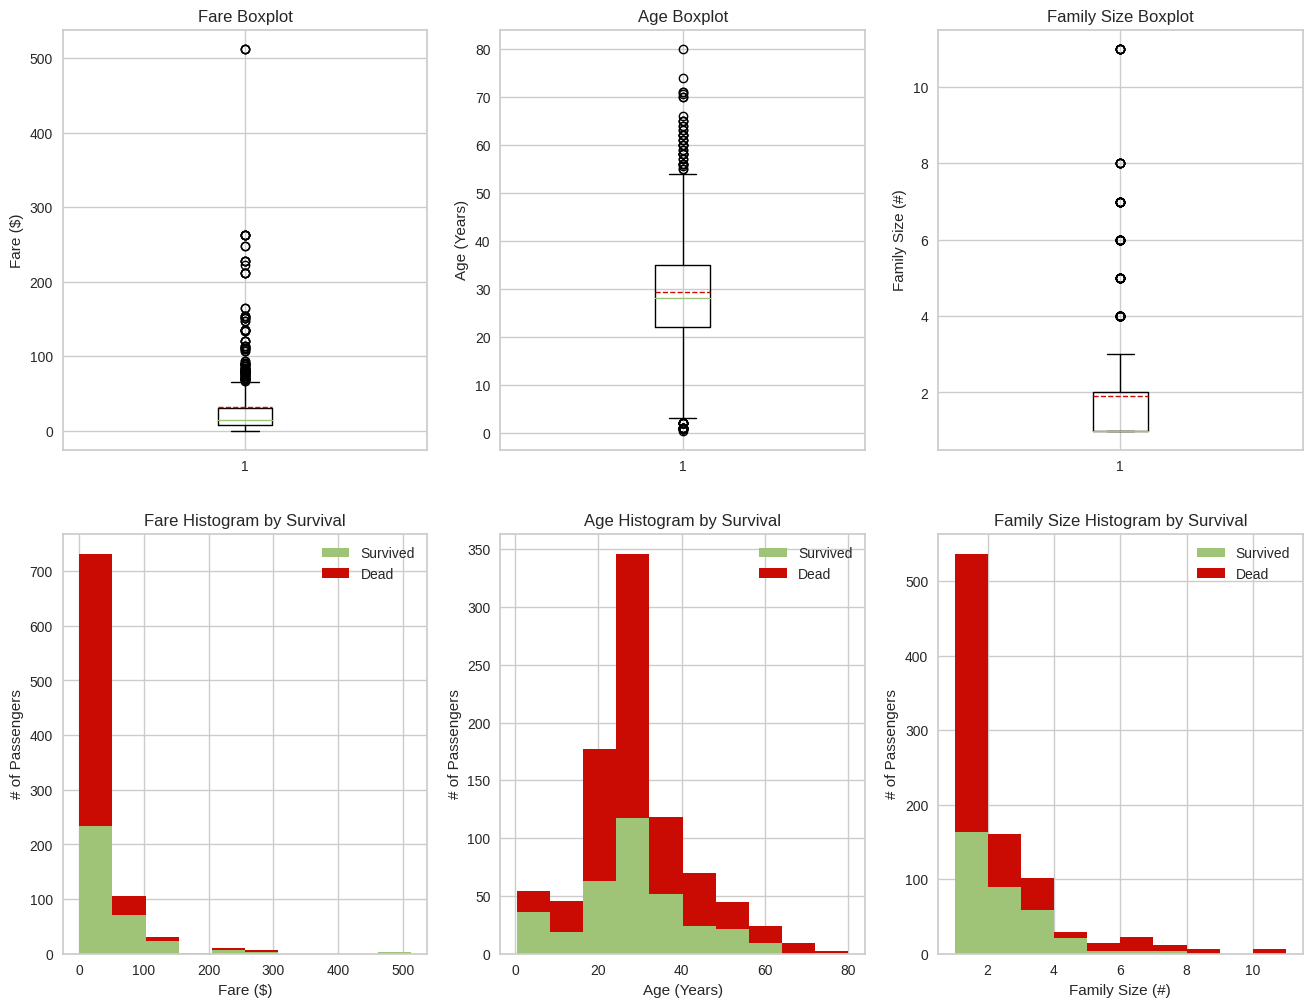

In [65]:
#graficamos distribuciones
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(train['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(train['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [train[train['Survived']==1]['Fare'], train[train['Survived']==0]['Fare']],
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [train[train['Survived']==1]['Age'], train[train['Survived']==0]['Age']],
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [train[train['Survived']==1]['FamilySize'], train[train['Survived']==0]['FamilySize']],
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

##### Revisamos 22 modelos!!

In [66]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    #Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),


    #xgboost:
    XGBClassifier()
    ]



#split del dataset en  cross-validation

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#creamos una tabla para comparar predicciones MLA
MLA_predict = train[Target]

#index a traves MLA y guardamos el  performance de la tabla
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    #score models
    cv_results = model_selection.cross_validate(alg, train[train_x_bin], train[Target], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()

    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3


    #guardamos MLA predictions
    alg.fit(train[train_x_bin], train[Target])
    MLA_predict[MLA_name] = alg.predict(train[train_x_bin])

    row_index+=1


#print and sort table:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict



,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.835206,0.827612,0.040916,0.046009
21,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.890824,0.826866,0.054656,0.044212
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.834082,0.826119,0.045663,0.05495
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.895131,0.825746,0.0605,0.198808
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.823134,0.064925,0.24717
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.866667,0.822761,0.049873,0.185979
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.889888,0.822388,0.049101,0.043704
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.822015,0.056205,0.003945
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.812313,0.076914,0.004037
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.820412,0.81194,0.049861,0.159618


Text(0, 0.5, 'Algorithm')

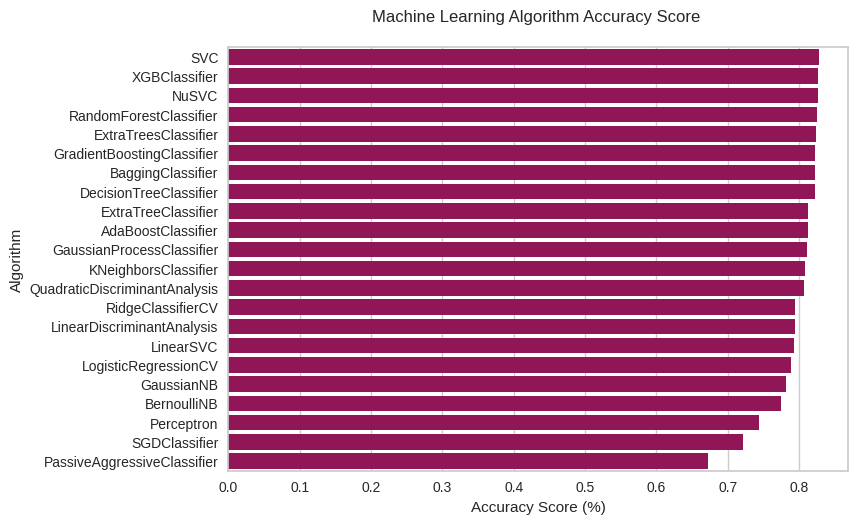

In [67]:
#barplot
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot:
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### 3. Reducción de dimensionalidad

In [ ]:
# Entrenamiento modelo PCA con escalado de los datos

# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(pd.concat([X_train_final,y_train], axis=1))

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.20974972 0.38962887 0.52725812 0.64051468 0.74961951 0.82011593
 0.88705539 0.94106993 0.98111776 1.        ]


Text(0, 0.5, 'Por. varianza acumulada')

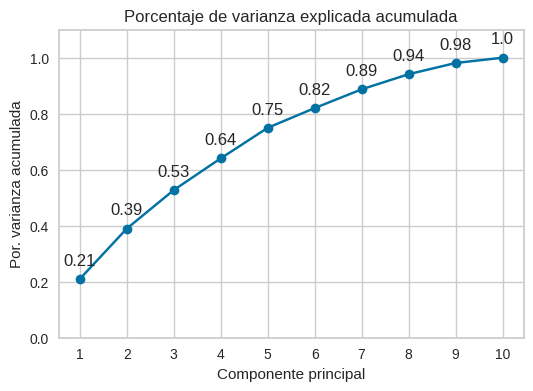

In [ ]:

datos=pd.concat([X_train_final,y_train], axis=1)
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

El número de componentes a seleccionar son 6 debido a que la variación total explicada acumulada en estas componentes es del 83% de la variación total existente en la matriz de datos está siendo explicada por las componentes PC1, PC 2,  PC3, PC4, PC5  y PC6 con una perdida mínima de información.

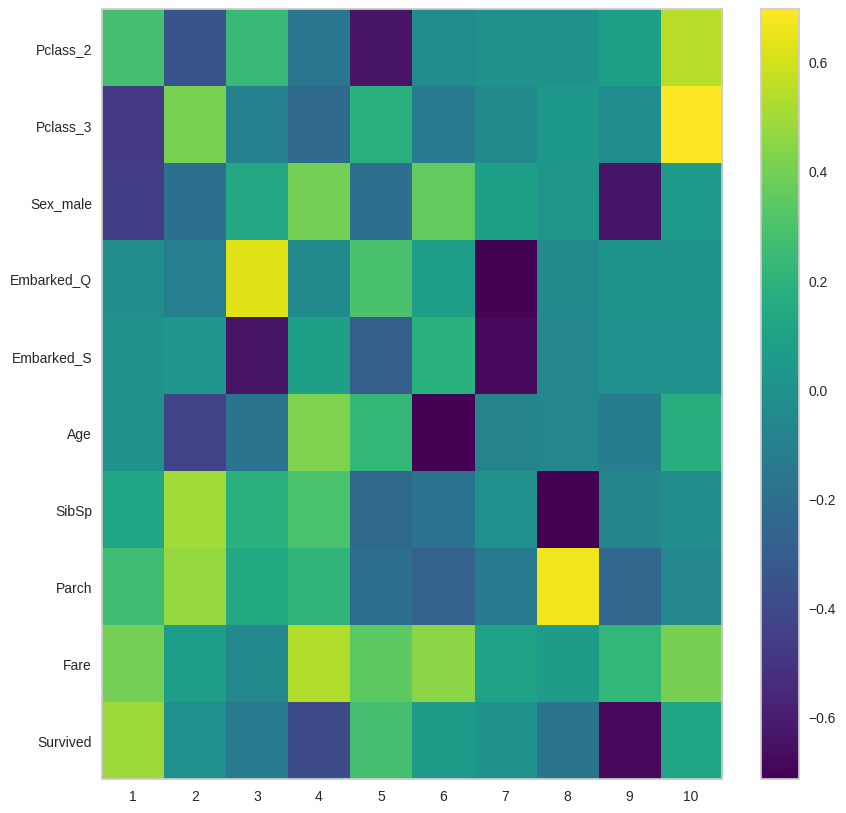

In [ ]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

Esta matriz de correlación entre las variables y las componentes se observa :
la primera componente es el resultado de la siguiente combinación lineal de las variables originales:
PC1 = 0,31Pclass_2 - 0.51Pclass_3 - 0.41Sex_male - 0.19 Embarked + 0.02 Embarked + 0.02 Age + 0.11 SibSp + 0.25Parch + 0.39Fare + 0.46 Survived
 En esta componente los mayores valores absolutos son los de las variables Pclass_3, Sex_male, Fare, y Survived. Se puede decir que esta componente PC1 captura la variabilidad asociada a la clase y el género, y su relación con el costo del boleto y la supervivencia.

Observaciones:
*	Las personas en tercera clase y los hombres tienen una tendencia negativa, mientras que aquellos con boletos más caros tienen una tendencia positiva.
*	Este componente podría estar capturando la variabilidad socioeconómica y su relación con la supervivencia.
PC2 = -0.37Pclass_2 +0.38 Pclass_3 - 0.27Sexmale+0.23Embarked_S - 0.39Age +0.44SibSp +0.42Parch + 0.12Fare + 0.10Survived
En el segundo componente principal, SibSp, Parch, y Age tienen las mayores cargas absolutas. Está relacionado principalmente con la estructura familiar (número de hermanos/esposos y número de padres/hijos) y la edad

Observaciones:
*	Las familias más grandes y las diferencias de edad parecen ser las principales contribuciones a este componente.
*	Este componente puede reflejar cómo la dinámica familiar y la edad afectan la variabilidad en los datos.

PC3 = -0.12 Pclass_2 - 0.06 Pclass_3 - 0.6 Sexmale + 0.52Embarked_S +0.60Embarked_Q + 0.21Age - 0.32SibSp +0.31Parch + 0.09Fare + 0.27Survived
El tercer componente principal está influenciado principalmente por Embarked_Q y Embarked_S.

Observaciones:
*	Existe una relación moderada con la supervivencia, indicando que los patrones de embarque pueden tener implicaciones en la supervivencia.
*	Este componente puede estar capturando diferencias geográficas y su impacto en los datos.

PC4 = -0.41 Pclass_2 - 0.12Pclass_3 - 0.31 Sexmale - 0.11Embarked_Q -0.09Embarked_S + 0.46Age + 0.16 SibSp +0.10 Parch + 0.62 Fare - 0.26Survived
En esta componente cuatro las variables con mayor valor absoluto es Fare y Age. Está fuertemente influenciado por la tarifa del boleto (Fare) y la edad (Age).

Observaciòn:
* La relación positiva con Sexmale y Fare sugiere que hombres de mayor edad y con boletos más caros están destacados en este componente.
* Este componente puede reflejar la influencia de factores económicos y etarios en los datos.

PC5 = -0.54 Pclass_2 - 0.27Pclass_3 + 0.30 Sexmale - 0.41 Embarked_Q -0.28Embarked_S - 0.05Age + 0.37SibSp +0.20Parch - 0.05 Fare - 0.35Survived
En esta componente quinta las variables con mayor valor absoluto en Pclass_2, Sex_male, y Survived.  Está influenciada por la clase 2, el género y el puerto de embarque.

Observaciones:
*	La relación negativa con la supervivencia (Survived) sugiere que este componente podría estar reflejando factores que disminuyen las probabilidades de supervivencia.
*	Este componente podría capturar la influencia de la clase social y ciertos perfiles demográficos en los datos.


PC6 = 0.00 Pclass_2 - 0.11 Pclass_3 + 0.36 Sexmale - 0.24 Embarked_Q -0.24Embarked_S - 0.72 Age - 0.20 SibSp - 0.24Parch + 0.35 Fare - 0.53Survived
La sexta componente principal está fuertemente influenciada por Age y Survived.
Es decir que está componente es fuertemente influenciada por la edad y la supervivencia, con una

Observaciones:
*	La relación positiva con Sexmale y Fare sugiere que hombres más jóvenes que pagaron más están destacados en este componente.
*	Este componente puede reflejar la importancia de la edad en la supervivencia y cómo interactúa con otros factores demográficos y económicos.


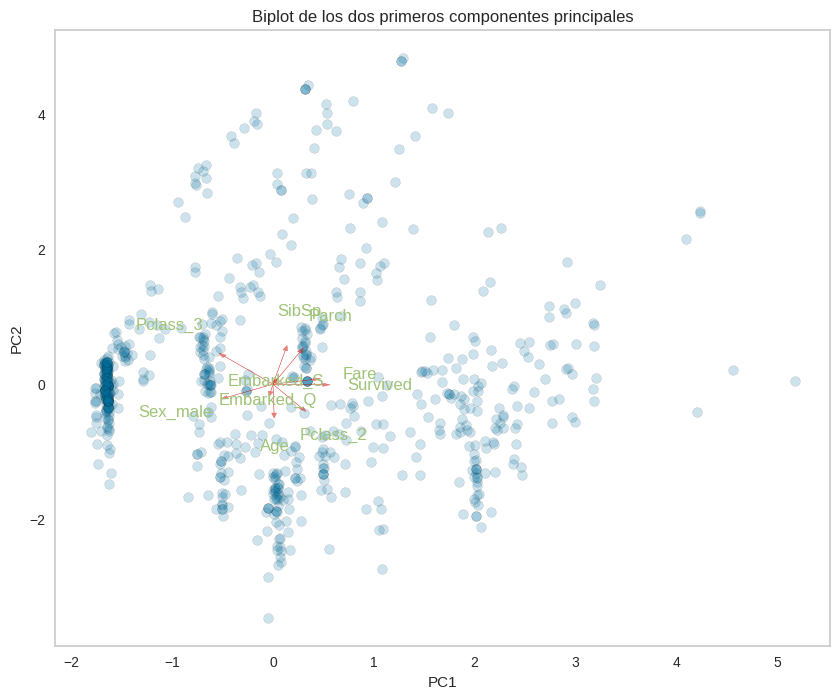

In [ ]:
# Entrenamiento del modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(datos)

# Obtener el modelo PCA entrenado
modelo_pca = pca_pipe.named_steps['pca']

# Transformar los datos originales a las proyecciones en componentes principales
proyecciones = pca_pipe.transform(datos)
proyecciones = pd.DataFrame(
    proyecciones,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
    index=datos.index
)
proyecciones = proyecciones.iloc[:, :6]

# Extraer las cargas de los componentes principales
cargas_pca = modelo_pca.components_

# Generar biplot de PC1 y PC2
def biplot(projections, pca_components, feature_names):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Proyecciones de las observaciones
    ax.scatter(projections.iloc[:, 0], projections.iloc[:, 1], alpha=0.2, edgecolors='k')

    # Vectores de características
    for i, (component, feature) in enumerate(zip(pca_components.T, feature_names)):
        ax.arrow(0, 0, component[0], component[1], color='r', alpha=0.5, head_width=0.05)
        ax.text(component[0] * 2.15, component[1] * 2.15, feature, color='g', ha='center', va='center')

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Biplot de los dos primeros componentes principales")
    plt.grid()
    plt.show()

# Nombre de las características originales
feature_names = datos.columns

# Generar el biplot
biplot(proyecciones, cargas_pca[:2, :], feature_names)

**Características de los vectores:**

El vector Parch y Pclass_2 forman aproximadamente un ángulo de 90° por lo cual son independientes.

El vector Embarked_S y Parch tienen un ángulo muy pequeño, por lo cual están muy relacionados entre si.

Los vectores Sex_male y Fare tienen un ángulo de aproximadamente 180° y ejerce una interpretación de forma de espejo. Es decir que los tripulantes se caracterizan por ser de género masculino, pero con una tarifa baja y los tripulantes que pagan una tarifa se caracterizan por no ser de género masculino.

**Interpretación de las componentes principales:**
*	Las variables que más aportan a la construcción de la componente PC1 son Fare, Survived y Sex_male son los que están más alejados del origen, pero más cercanos al eje de la componente uno.
*	Las variables que más aportan a la construcción de la componente PC2 son SibSp, Parch y Age son los que están más alejados del origen, pero más cercanos al eje de la componente uno.


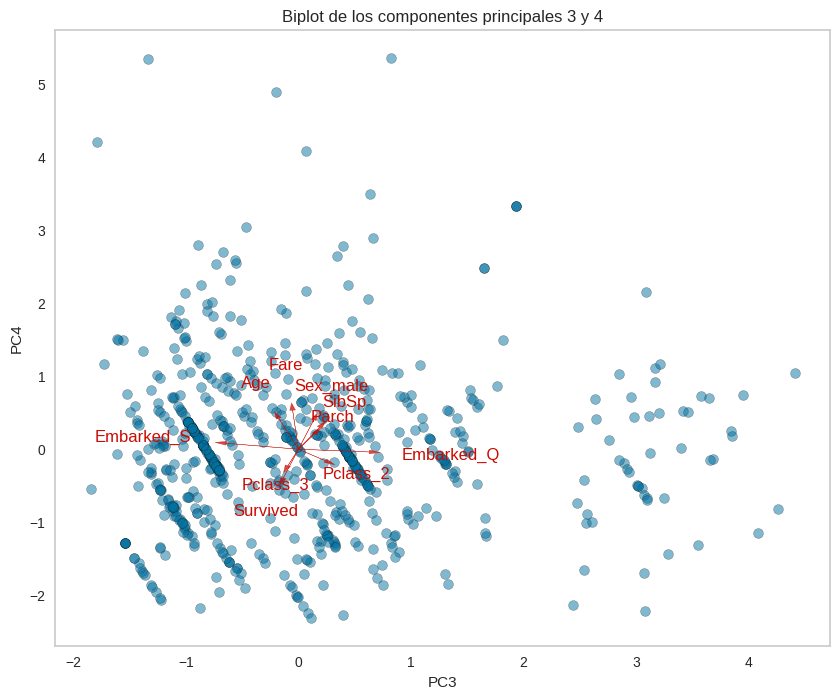

In [ ]:
# Generar biplot de PC3 y PC4
def biplot_pc3_pc4(projections, pca_components, feature_names):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Proyecciones de las observaciones
    ax.scatter(projections.iloc[:, 2], projections.iloc[:, 3], alpha=0.5, edgecolors='k', s=50)

    # Vectores de características
    for i, (component, feature) in enumerate(zip(pca_components.T, feature_names)):
        ax.arrow(0, 0, component[2], component[3], color='r', alpha=0.75, head_width=0.05, head_length=0.1)
        ax.text(component[2] * 2.15, component[3] * 2.15, feature, color='r', ha='center', va='center', fontsize=12)

    ax.set_xlabel("PC3")
    ax.set_ylabel("PC4")
    ax.set_title("Biplot de los componentes principales 3 y 4")
    plt.grid()
    plt.show()

# Generar el biplot con las proyecciones y las cargas PCA
biplot_pc3_pc4(proyecciones, cargas_pca[:4, :], datos.columns)

**Características de los vectores:**

El vector Age y Parch forman aproximadamente un ángulo de 90° por lo cual son independientes.
El vector SibSp y Parch tienen un ángulo muy pequeño, por lo cual están muy relacionados entre sí.
Los vectores Embarked_S y Embarked_Q tienen un ángulo de aproximadamente 180° y ejerce una interpretación de forma de espejo. Es decir que los tripulantes se caracterizan por el puerto desde el cual el la mayoría de los pasajero embarcó era Southampton, pero con una  baja presencia de los pasajeros de Queenstown y los tripulantes que pagan una tarifa se caracterizan por no ser de género masculino.

**Interpretación de las componentes principales:**
*	Las variables que más aportan a la construcción de la componente PC3 son Embarked_S y Embarked_Q son los que están más alejados del origen, pero más cercanos al eje de la componente uno.
*	Las variables que más aportan a la construcción de la componente PC4 son Pclass_3, Survived y Sex_male son los que están más alejados del origen, pero más cercanos al eje de la componente uno.


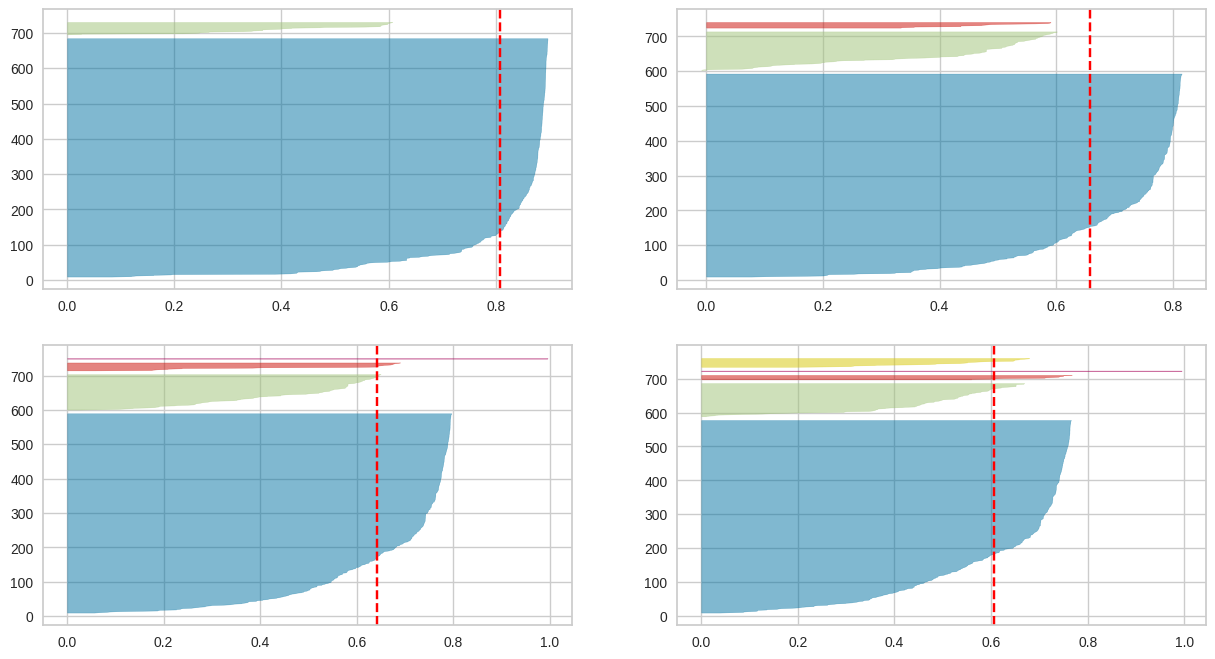

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(datos) #Vemos que el valor óptimo es K=2

### 4. Caracterización de los pasajeros

In [ ]:

km = KMeans(n_clusters=2 ,init='k-means++', max_iter=300, n_init=10, random_state=0)
#
# Fit the KMeans model
#
km.fit_predict(datos)
#
# Calculate Silhoutte Score
#
score = silhouette_score(datos, km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)
cluster_labels = km.fit_predict(datos)
cluster_label_mapping = {
    0: 'Cluster 1',
    1: 'Cluster 2',
    # Agregar más etiquetas según sea necesario para tus datos
}


# Agregar una nueva columna con las etiquetas de los clusters al DataFrame
df_train['Cluster_Labels'] = cluster_labels

# Aplicar el mapeo a la columna 'Cluster_Labels' utilizando el método map
df_train['Cluster_Labels'] = df_train['Cluster_Labels'].map(cluster_label_mapping)
# Mostrar las primeras filas del DataFrame para verificar que se ha agregado la columna
print(df_train.head())


Silhouetter Score: 0.808
    Survived Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize  \
331        0      1    male  45.5    0.0    0.0  28.5000        C         1.0   
733        0      2    male  23.0    0.0    0.0  13.0000      NaN         1.0   
382        0      3    male  32.0    0.0    0.0   7.9250        Q         1.0   
704        0      3    male  26.0    1.0    0.0   7.8542        S         2.0   
813        0      3  female   6.0    4.0    2.0  31.2750      NaN         7.0   

     IsAlone Cluster_Labels  
331        1      Cluster 2  
733        1      Cluster 2  
382        1      Cluster 2  
704        0      Cluster 2  
813        0      Cluster 2  


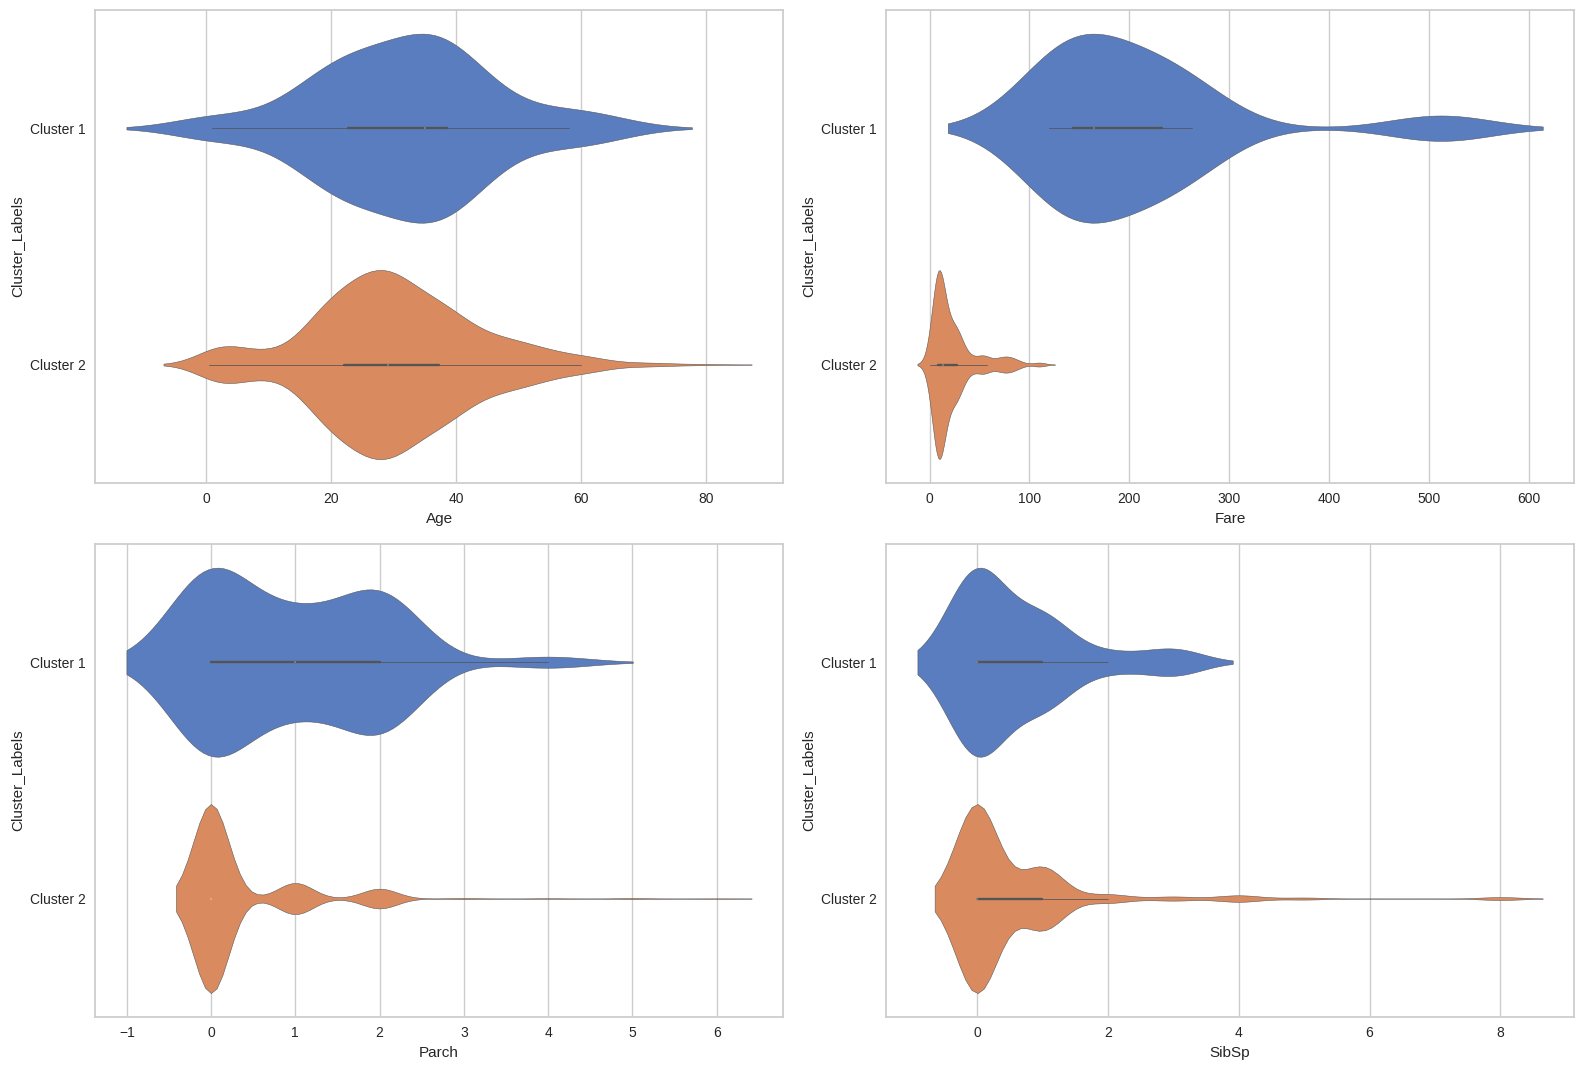

In [ ]:
# Visualización de las variables cuantitativas vs Survived
df_train['Cluster_Labels'] = df_train['Cluster_Labels'].astype('category')

# Definir las variables cualitativas y cuantitativas
qualitative_cols = ['Sex', 'Embarked']
quantitative_cols = ['Age', 'Fare', 'Parch', 'SibSp']

# Crear un tablero para gráficos de violín de variables cuantitativas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('', fontsize=16)

for i, col in enumerate(quantitative_cols):
    ax = axes[i // 2, i % 2]
    sns.violinplot(y='Cluster_Labels', x=col, data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [ ]:
# Visualización de variables cualitativas vs Survived
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('', fontsize=16)

for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='Cluster_Labels', data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
sns.pairplot(data=df_train[['Age', 'Fare', 'Parch', 'SibSp','Cluster_Labels']], hue="Cluster_Labels")